# Correlating Idyoms and Contrast Information 

This note book contains the code used to compute and calculate the different information profiles, plot them, and compute different correlations for the Nova data set.

In [1]:
using Chakra
include("./Idyoms.jl")
using Main.Idyoms

### 1. Load seqeunce data

In [2]:
using Melch
Melch.__INIT__("/Users/nick/Work/MelchData")
nova = fnd(Melch.id(0),Melch)
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

### 2. Define viewpoints

In [3]:
P = vp(Melch.CPITCH)
D = vp(Melch.DUR)
PxD = link(P,D)

Chakra.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:CPITCH, Int64}(), Type[Int64]), Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:DUR, Int64}(), Type[Int64])], DataType[Int64, Int64])

In [4]:
V = PxD
n,m = Bounded(5),Bounded(1);
#output = "fci-P.csv"

In [5]:
views = [View(seq,V,V,V) for seq in sequences];
gs = NMgs(views,n,m);

### 5. Construct tallies from ngrams

In [6]:
txyZ = Idyoms.tally_xyZ(gs);
txzY = Idyoms.tally_xzY(gs);
txZ = Idyoms.tally_xZ(gs);
tyZ = Idyoms.tally_yZ(gs);
txY = Idyoms.tally_xY(gs);

### 6. Construct alphabets from ngrams

In [7]:
dX = Set([g[1] for g in gs]);
dY = Set([g[2] for g in gs]);
dZ = Set([g[3] for g in gs]);

### 7. Compute PPM distributions

In [8]:
# PARAMTERS

b = Backoff()
e = C()
u = false

# DISTRIBUTIONS

dist(x,t,s,a,b,e,u) = Idyoms.estimate_dist(x,t,s,a,b,e,u)[1];

pZxy(x::Seq{X},y::Y) where {X,Y} = dist((x=>y),txyZ,dZ,dZ,b,e,u);
pZy(y::Y) where Y = @views dist([y][1:end],tyZ,dZ,dZ,b,e,u);
pZx(x::Seq{X}) where X = dist(x,txZ,dZ,dZ,b,e,u);
pYx(x::Seq{X}) where X = dist(x,txY,dY,dY,b,e,u);
pYxz(x::Seq{X},z::Z) where {X,Z} = dist((x=>z),txzY,dY,dY,b,e,u);

### 8. Compute forward contrast information

In [9]:
function FCI(x::Seq{X},y::Y,z::Seq{Z}) where {X,Y,Z}

    pzxy = pZxy(x,y)
    pzx = pZx(x)
    pzy = pZy(y)
    pyxz = pYxz(x,z)
    pyx = pYx(x)

    fpc = sum([pzxy(z)*log(2,pzxy(z)/pzx(z)) for z in dZ])
    fcc = sum([pzxy(z)*log(2,pzxy(z)/pzy(z)) for z in dZ])
    frc = sum([pyxz(y)*log(2,pyxz(y)/pyx(y)) for y in dY])
    ic = Idyoms.infcontent(pyx,y)
    h = Idyoms.entropy(pyx)

    efpc = 0
    for y in dY
        p = pZxy(x,y)
        ci = sum([p(z)*log(2,p(z)/pzx(z)) for z in dZ])
        efpc += pyx(y)*ci
    end
    
    return fpc, fcc, frc, pyx(y), pzxy(z), pzx(z), pzy(z), pyxz(y), ic, h, efpc
    
end

function FCI(v::View{X,Y,Z}) where {X,Y,Z}
    
    fci = [FCI(nmg(v,i,n,m)...) for i in 1:length(v)]
    fpc = [t[1] for t in fci];
    fcc = [t[2] for t in fci];
    frc = [t[3] for t in fci];
    pyx = [t[4] for t in fci];
    pzxy = [t[5] for t in fci];
    pzx = [t[6] for t in fci];
    pzy = [t[7] for t in fci];
    pyxz = [t[8] for t in fci];
    ic = [t[9] for t in fci];
    h = [t[10] for t in fci];
    efpc = [t[11] for t in fci];
    
    return fpc, fcc, frc, pyx, pzxy, pzx, pzy, pyxz, ic, h, efpc 

end

@time fci = [FCI(view) for view in views];

689.599381 seconds (15.35 G allocations: 2.208 TiB, 16.00% gc time, 0.11% compilation time)


In [10]:
fpc = vcat([t[1] for t in fci]...);
fcc = vcat([t[2] for t in fci]...);
frc = vcat([t[3] for t in fci]...);
pyx = vcat([t[4] for t in fci]...);
pzxy = vcat([t[5] for t in fci]...);
pzx = vcat([t[6] for t in fci]...);
pzy= vcat([t[7] for t in fci]...);
pyxz= vcat([t[8] for t in fci]...);
ic = vcat([t[9] for t in fci]...);
h = vcat([t[10] for t in fci]...);
efpc = vcat([t[11] for t in fci]...);

In [11]:
using DataFrames
df = DataFrame(pyx=pyx,ic=ic,h=h,fpc=fpc,efpc=efpc);
print(df)

8552×5 DataFrame
  Row │ pyx          ic           h          fpc        efpc      
      │ Float64      Float64      Float64    Float64    Float64   
──────┼───────────────────────────────────────────────────────────
    1 │ 0.0602198     4.05362     5.69385    2.9461     2.77719
    2 │ 0.0673478     3.89222     4.49233    4.44346    4.14128
    3 │ 0.0492809     4.34283     3.82183    4.37668    4.38649
    4 │ 0.748418      0.418083    1.81882    4.41795    4.7096
    5 │ 0.363331      1.46065     2.52502    3.46157    3.51423
    6 │ 0.817129      0.291363    1.31821    1.94968    2.72224
    7 │ 0.642207      0.638889    1.8466     1.2097     2.56237
    8 │ 0.773673      0.370204    1.49892    0.974833   2.18947
    9 │ 0.863035      0.212509    0.971834   1.06247    1.81702
   10 │ 0.333733      1.58324     2.45895    2.71678    3.35668
   11 │ 0.898326      0.154688    0.863993   0.846249   1.56257
   12 │ 0.872698      0.196446    0.965489   0.509582   1.51328
   13 │ 0.93115

Excessive output truncated after 524288 bytes.

# Correlation
Pearson, Spearman, Kendall

In [12]:
using Statistics, StatsBase

## Information Content v. Forward Predictive Contrast Information 

In [13]:
# aggregate correlation
cor(fpc,ic), corspearman(fpc,ic), corkendall(fpc,ic)

(0.22729716677885348, 0.39291945300253844, 0.27071918570648457)

In [14]:
# melody-wise correlation
mean([cor(d[1],d[9]) for d in fci]), mean([corspearman(d[1],d[9]) for d in fci]), mean([corkendall(d[1],d[9]) for d in fci])

(0.26634263109844236, 0.4221679201443265, 0.299454336090927)

## Entropy v. Expected Contrast Information

In [15]:
cor(h,efpc), corspearman(h,efpc), corkendall(h,efpc)

(0.36643006954926044, 0.5312294130728759, 0.3790198357016788)

In [16]:
mean([cor(d[10],d[11]) for d in fci]), mean([corspearman(d[10],d[11]) for d in fci]), mean([corkendall(d[10],d[11]) for d in fci])

(0.32543340035213686, 0.5357254980399165, 0.3980141998216593)

# Plotting
## Standard Idyoms

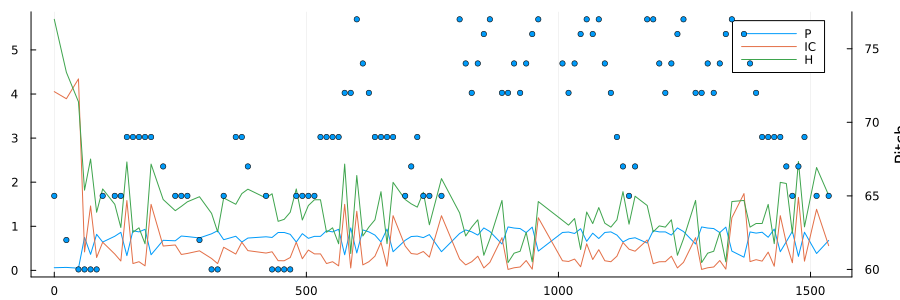

In [17]:
using Plots
m = 1
seq = sequences[m]
fpc, fcc, frc, pyx, pzxy, pzx, pzy, pyxz, ic, h, efpc = fci[m]

onsets = [e.ONSET for e in seq];
durations = [e.DUR for e in seq];
pitches = [e.CPITCH for e in seq];
phrase_start = [e.ONSET for e in seq if e.PHRASE == 1];
phrase_end = [e.ONSET for e in seq if e.PHRASE == -1];

plot(size=(900,300))
plot!(onsets,pyx,label="P")    
plot!(onsets,ic,label="IC")
plot!(onsets,h,label="H")     
scatter!(twinx(),onsets,pitches,label="pitch",markersize=3,ylabel="Pitch",legend=false)

## Information content v. forward predictive contrast information

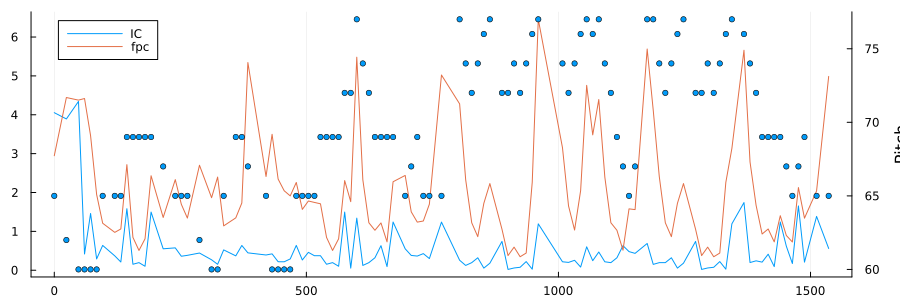

In [18]:
plot(size=(900,300))
plot!(onsets,ic,label="IC")
plot!(onsets,fpc,label="fpc")
scatter!(twinx(),onsets,pitches,label="pitch",markersize=3,ylabel="Pitch",legend=false)

## Entropy v. expected contrast information

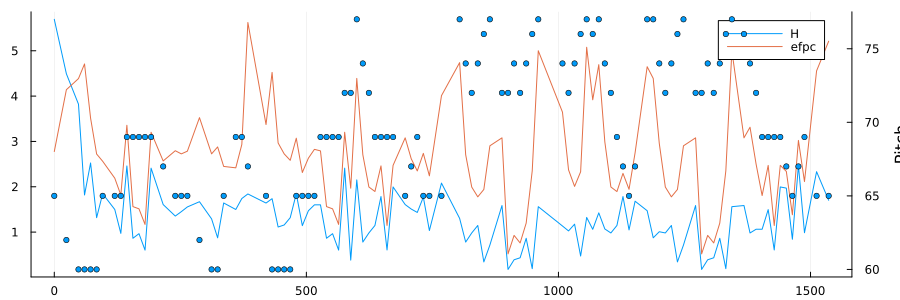

In [19]:
plot(size=(900,300))
plot!(onsets,h,label="H")
plot!(onsets,efpc,label="efpc")        
scatter!(twinx(),onsets,pitches,label="pitch",markersize=3,ylabel="Pitch",legend=false)